In [1]:
# imports
import librosa, os
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
import numpy as np
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf

from tqdm.notebook import tqdm
from random import sample
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn import svm, neighbors, model_selection, manifold
from statistics import mean
from sklearn.metrics import classification_report
from skimage.measure import block_reduce

from pyha_analyzer import PyhaTrainer, PyhaTrainingArguments, extractors
from pyha_analyzer.models.demo_CNN import ResnetConfig, ResnetModel
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessors
from pyha_analyzer.models import EfficentNet

import lapjv


import torch


In [2]:
resnet50d_config = ResnetConfig(
    num_classes=2, itorchut_channels=1, problem_type = "multi_label_classification", output_hidden_states = True
)

#model = EfficentNet(num_classes=len(coral_ads["train"].features["labels"].names))
model = EfficentNet(num_classes=2)
model.load_state_dict(torch.load('/home/a.jajodia.229/acoustic/acoustic_knowledge_discovery/pyha-analyzer-2.0/coral_model_4146a1f.pt'))

<All keys matched successfully>

In [3]:
lag = 512

# juan colonna entropy

def Entropy(p1):
    p1 = p1/np.sum(p1)
    return entropy(p1)/np.log(len(p1))
# EGCI calculation from https://github.com/juancolonna/EGCI/blob/master/Example_of_EGCI_calculation.ipynb

def JSD(p):
    n = len(p)
    q = np.ones(n)/n # Uniform reference
    p = np.asarray(p)
    q = np.asarray(q)
    p = p/p.sum() # normalize
    m = (p + q) / 2
    jensen0 = -2*((((n+1)/n)*np.log(n+1)-2*np.log(2*n) + np.log(n))**(-1))
    return jensen0*(entropy(p, m) + entropy(q, m)) / 2

def EGCI(x):
    x = zscore(x)
    
    # Algorithm steps 
    rxx = acf(x, nlags=lag, adjusted=True, fft=True) #https://github.com/blue-yonder/tsfresh/issues/902
    Sxx = toeplitz(rxx)
    U, s, Vt = np.linalg.svd(Sxx) #svd(Sxx)
    
    return Entropy(s), Entropy(s)*JSD(s) 

def process_data(data):
    path = data["filepath"]
    
    if (".WAV" not in path) and (".wav" not in path) and (path.contains('part')):
        print("directory found")
        return None
    
    i = 0
    audio, sr = librosa.load(path, sr=data['sample_rate'], duration=5, offset=i)

    
    if librosa.get_duration(y = audio, sr = sr) == 0:
        return None
    
    h, c = EGCI(audio)

    
    
    output_data = {
            "path": path,
            "offset_s": 0,
            "sr": sr,
            "gt": data['labels'],
            "site": data['labels'],
            "entropy": h,
            "complexity": c
        }
    return output_data

In [4]:
# getting all the wavs

audio_path = "/home/a.jajodia.229/acoustic/local_data/coral"

music_extractor = extractors.Music()
music_ads = music_extractor("/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest")

Casting the dataset:   0%|          | 0/498 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

In [5]:
df = music_ads['train'].to_pandas()

In [6]:
mask = df['filepath'].str.contains('part')

In [7]:
def process_data_multiprocess(paths, process_data_func=process_data,  processes=8, sample=250):
    sample = paths.sample(sample)
    # sample = paths
    
    samples = list(sample.T.to_dict().values())
    
    
    with Pool(processes) as p:
        data = list(tqdm(p.imap(process_data_func, samples)))
    return data

In [8]:
data = [process_data(df.iloc[i]) for i in tqdm(range(200))]

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
df = pd.DataFrame.from_records(data)

/tmp/ipykernel_32435/791502406.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(df, x = 'entropy', y = 'complexity', palette='Set3')


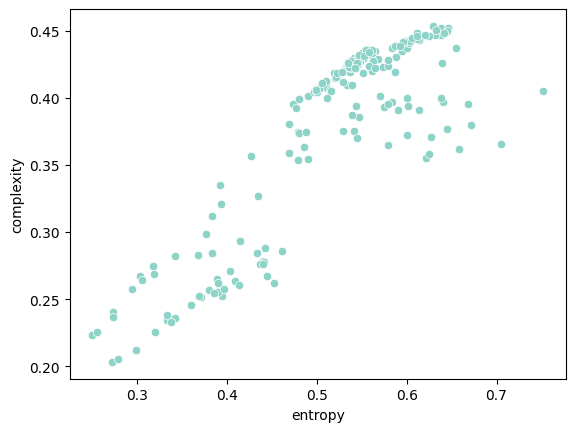

In [10]:
with sns.color_palette("Set3"):
    sns.scatterplot(df, x = 'entropy', y = 'complexity', palette='Set3')

In [11]:
data

[{'path': '/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Zoom_F3/030525_003_20250503_174500_part_046.wav',
  'offset_s': 0,
  'sr': np.int64(96000),
  'gt': array([1, 0]),
  'site': array([1, 0]),
  'entropy': np.float64(0.46929746081914725),
  'complexity': np.float64(0.3585961878585504)},
 {'path': '/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Zoom_F3/030525_004_20250503_183415_part_036.wav',
  'offset_s': 0,
  'sr': np.int64(96000),
  'gt': array([1, 0]),
  'site': array([1, 0]),
  'entropy': np.float64(0.5731663673342144),
  'complexity': np.float64(0.4232400556569502)},
 {'path': '/home/a.jajodia.229/acoustic/local_data/muha/Liked Sounds/Location A Sand Forrest/Zoom_F3/030525_001_20250503_163053_part_080.wav',
  'offset_s': 0,
  'sr': np.int64(96000),
  'gt': array([1, 0]),
  'site': array([1, 0]),
  'entropy': np.float64(0.38022486322027255),
  'complexity': np.float64(0.2568860307889341)},
 {'path': '/home/

In [ ]:
preprocessor = MelSpectrogramPreprocessors(duration=5, class_list=music_ads["train"].features["labels"].feature.names)

music_ads["train"].set_transform(preprocessor)

data = music_ads['train'].filter(lambda row: row['filepath'])[0:100]

In [13]:
samples = np.array(data['audio']).squeeze()

In [14]:
samples.shape

(100, 256, 431)

In [15]:
data_root = 'data/drums/'
sr = 48000
max_length = sr*4 # ignore samples longer than 4 seconds
fixed_length = sr/4 # trim all samples to 250 milliseconds
limit = None # set this to 100 to only load the first 100 samples

In [16]:
def load_sample(fn, sr=None,
                max_length=None, fixed_length=None, normalize=True):
    if fn == '': # ignore empty filenames
        return None
    audio, _ = librosa.load(fn)
    duration = len(audio)
    if duration == 0: # ignore zero-length samples
        return None
    if max_length and duration >= max_length: # ignore long samples
        return None
    if fixed_length:
        np.resize(audio, fixed_length)
    max_val = np.abs(audio).max()
    if max_val == 0: # ignore completely silent sounds
        return None
    if normalize:
        audio /= max_val
    return (fn, audio, duration)

In [17]:
max_length = sr*4 # ignore samples longer than 4 seconds
fixed_length = sr//4 # trim all samples to 250 milliseconds
limit = None # set this to 100 to only load the first 100 samples

In [30]:
sample = [load_sample(filepath, max_length=max_length, fixed_length=fixed_length) for filepath in data['filepath']]

sample = [i[1] for i in sample if i is not None]

In [40]:
sample[0].shape

(110309,)

In [31]:
n_fft = 128
hop_length = int(n_fft/4)
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = 100 # set this to 100 to only process 100 samples

window = np.hanning(n_fft)
def job(y):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    amp = np.abs(S)
    if reduce_rows > 1 or reduce_cols > 1:
        amp = block_reduce(amp, (reduce_rows, reduce_cols), func=np.mean)
    if amp.shape[1] < crop_cols:
        amp = np.pad(amp, ((0, 0), (0, crop_cols-amp.shape[1])), 'constant')
    amp = amp[:crop_rows, :crop_cols]
    if use_logamp:
        amp = librosa.logamplitude(amp**2)
    amp -= amp.min()
    if amp.max() > 0:
        amp /= amp.max()
    amp = np.flipud(amp) # for visualization, put low frequencies on bottom
    return amp
pool = Pool()
fingerprints = pool.map(job, samples[:limit])
fingerprints = np.asarray(fingerprints).astype(np.float32)

ValueError: `block_size` must be a scalar or have the same length as `image.shape`

In [ ]:
fingerprints.reshape((100, 224)).shape

(100, 224)

In [ ]:
# get 2d embeddings
tsne = manifold.TSNE(random_state = 1, n_components=2, learning_rate=50)
data2d = tsne.fit_transform(fingerprints.reshape((100,224)))

data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)

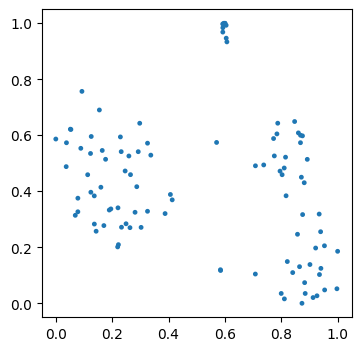

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(data2d[:,0], data2d[:,1], edgecolors='none', marker='o', s=12)  
plt.show()

side = 10
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)


In [ ]:
from scipy.spatial.distance import cdist
cost = cdist(grid, data2d, 'sqeuclidean')
cost = cost * (10000000. / cost.max())

In [ ]:
cost

array([[6806780.12640216, 1180438.54202511, 2055559.8227529 , ...,
        1816825.27042568, 2642430.64609001, 5598850.83802703],
       [6176700.7128693 , 1112944.60194572, 2060095.04155236, ...,
        1882008.66248232, 2526258.06705749, 4617108.17562084],
       [5676988.08344972, 1175817.44597961, 2194997.0444651 , ...,
        2077558.83865223, 2540452.27213824, 3765732.29732792],
       ...,
       [ 186336.91389467, 3877413.70455687, 3538715.92774389, ...,
        4096290.22532509, 2556888.80055152, 1316125.99905749],
       [ 468824.98915474, 4722487.2532704 , 4455818.63533627, ...,
        5074041.10617465, 3353283.71031192, 1246950.82544422],
       [ 881679.84852808, 5697927.58609721, 5503288.12704194, ...,
        6182158.77113749, 4280045.4041856 , 1308142.43594423]],
      shape=(100, 100))

In [ ]:
col_assigns

(18477926.0,
 array([1044990.1  ,  942331.06 ,  880390.44 ,  945647.   ,  715972.1  ,
         489080.72 ,  254480.75 ,   77035.48 ,       0.   ,   13421.506,
         778189.2  ,  681924.7  ,  641565.3  ,  694002.1  ,  641120.94 ,
         513114.88 ,  289672.8  ,  101113.43 ,   33830.17 ,   17785.658,
         605169.9  ,  541432.4  ,  512460.28 ,  556339.2  ,  672690.5  ,
         586139.2  ,  356617.38 ,  189285.25 ,  108977.1  ,  113421.19 ,
         547678.56 ,  476653.72 ,  438374.78 ,  500907.2  ,  613075.3  ,
         754434.2  ,  494689.7  ,  335879.4  ,  231864.12 ,  221543.78 ,
         563603.8  ,  482870.72 ,  490740.1  ,  548428.06 ,  667674.4  ,
         777298.1  ,  543410.75 ,  432158.38 ,  382364.9  ,  393992.94 ,
         577706.25 ,  544079.94 ,  557454.1  ,  594736.4  ,  741469.06 ,
         787843.9  ,  593601.1  ,  505330.53 ,  488148.8  ,  561996.5  ,
         645755.5  ,  633385.75 ,  671102.75 ,  706535.6  ,  837750.44 ,
         925195.06 ,  732482.25 ,  655

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

cmap = cm.viridis
norm = Normalize(vmin=0, vmax=3) # Adjust vmin/vmax based on your data range

min_cost, row_assigns, col_assigns = lapjv.lapjv(np.copy(cost))
grid_jv = grid[col_assigns]
print(col_assigns.shape)
plt.figure(figsize=(4, 4))
for index, (start, end) in enumerate(zip(data2d, grid_jv)):
    arrow_color = cmap(norm(data['site'][index]))
    
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01, fc=arrow_color, ec=arrow_color)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices